## ASSIGNMENT-1: Transformations, Mapping and Data Representations

Roll number: 2022900038

### Instructions
 * Fill in the roll-number in the cell above.
 * Code must be written in Python in Jupyter Notebooks. We highly recommend using anaconda distribution or at the minimum, virtual environments for this assignment.
 * All the code and result files should be uploaded in the github classroom.
 * For this assignment, you will be using Open3D and AI2Thor extensively. Refer to [Open3D](http://www.open3d.org/docs/release/) and [AI2Thor](https://github.com/allenai/ai2thor) documentation.
 *  Most of the questions require you to **code your own functions** unless there is a need to call in the abilities of the mentioned libraries, such as Visualisation from Open3D. Make sure your code is modular since you will be reusing them for future assignments. All the functions related to transformation matrices, quaternions, and 3D projection are expected to be coded by you.
 *  All the representations are expected to be in a right-hand coordinate system.
<!--  * Answer to the descriptive questions should be answered in your own words. Copy-paste answers will lead to penalty. -->
 * You could split the Jupyter Notebook cells where TODO is written, but please try to avoid splitting/changing the structure of other cells.
 * All the visualization should be done inside the notebook unless specified otherwise.
 * Plagiarism will lead to heavy penalty.
 * Commit this notebook in the repo and any other results files under the result folder in the GitHub Classroom repo. 
 * Commits past the deadline will not be considered.

In [1]:
# List the imports here
import numpy as np
from scipy.optimize import fsolve
import open3d as o3d
import time
from ai2thor.controller import Controller
from pynput import keyboard
import cv2
import pandas as pd
import shutil
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### SECTION 1: Transformations and representations

#### 1.1 Euler angles

a. Write a function that returns a rotation matrix given the angles (𝛼, 𝛽, 𝛾) = (π/6, 7π/18, 2π/9) in radians (X-Y-Z). Do not use inbuilt functions.

b. Solve for angles using fsolve from scipy for three initializations of your choice and compare.
$$M(\alpha , \beta ,\gamma)=\left[\begin{array}{rrr}0.72907076 & -0.56745855 & 0.38268343 \\0.64785386 & 0.39180184 & -0.65328148 \\
    0.22077409 & 0.72421137 & 0.65328148\end{array}\right] 
$$

c. Show an example where a Gimbal lock occurs and visualize the Gimbal lock on the given point cloud, data/toothless.ply. You have to show the above by animation (rotation along each axis one by one).

Hint: Use Open3D's non-blocking visualization and discretize the rotation to simulate the animation. For example, if you want to rotate by 20° around a particular axis, do so in increments of 5° 4 times to make it look like an animation.

In [2]:
##############################################################################
# TODO: Do tasks described in 1.1 (a)
##############################################################################

def rotation_matrix(alpha, beta, gamma):
    Rx = np.array([[1, 0, 0],
                   [0, np.cos(alpha), -np.sin(alpha)],
                   [0, np.sin(alpha), np.cos(alpha)]])
    
    Ry = np.array([[np.cos(beta), 0, np.sin(beta)],
                   [0, 1, 0],
                   [-np.sin(beta), 0, np.cos(beta)]])
    
    Rz = np.array([[np.cos(gamma), -np.sin(gamma), 0],
                   [np.sin(gamma), np.cos(gamma), 0],
                   [0, 0, 1]])
    
    return Rz.dot(Ry.dot(Rx))

alpha = np.pi / 6
beta = 7 * np.pi / 18
gamma = 2 * np.pi / 9

rotation_matrix_result = rotation_matrix(alpha, beta, gamma)
print(rotation_matrix_result)

##############################################################################
# END OF YOUR CODE
##############################################################################

[[ 0.26200263 -0.19674724  0.944799  ]
 [ 0.21984631  0.96542533  0.14007684]
 [-0.93969262  0.17101007  0.29619813]]


In [3]:
##############################################################################
# TODO: Do tasks described in 1.1 (b)
##############################################################################

def error_func(angles,matrix):
    mat = rotation_matrix(angles[0],angles[1],angles[2])
    mt = np.multiply(mat,matrix) - np.eye(3)
    error = np.sum(mt,1) 
    return error

target_rotation_matrix = np.array([
    [0.72907076, -0.56745855, 0.38268343],
    [0.64785386, 0.39180184, -0.65328148],
    [0.22077409, 0.72421137, 0.65328148]])

initialization1 = [0, 0, 0]
initialization2 = [1, 0.2, 0.7]
initialization3 = [-1, -0.2, -0.7]

final_angles = fsolve(error_func,initialization1,args=target_rotation_matrix)
print(final_angles)
final_angles = fsolve(error_func,initialization2,args=target_rotation_matrix)
print(final_angles)
final_angles = fsolve(error_func,initialization3,args=target_rotation_matrix)
print(final_angles)

##############################################################################
# END OF YOUR CODE
##############################################################################

[ 0.83683745 -0.22260301  0.72648416]
[ 0.83689025 -0.22263414  0.72650166]
[ 0.83683003 -0.22259514  0.72648495]


/home/saksham/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/home/saksham/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [4]:
##############################################################################
# TODO: Do tasks described in 1.1 (c)
##############################################################################

home = o3d.io.read_point_cloud('data/toothless.ply')
home.translate(-home.get_center())
homes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=100)
homes.translate((0, 0, 0))
frame1 = o3d.io.read_point_cloud('data/toothless.ply')
frame1.translate(-frame1.get_center())

vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(homes)
vis.add_geometry(frame1)

print("ROTATING ABOUT Y BY 90")
for y in range(91):
    rotation_matrix_result = rotation_matrix(np.radians(0), np.radians(y), np.radians(0))
    frame1.points = o3d.utility.Vector3dVector(np.dot(np.asarray(home.points),rotation_matrix_result))
    vis.update_geometry(frame1)
    vis.poll_events()
    vis.update_renderer()
    time.sleep(0.01)
    
print("ROTATING ABOUT X BY 90")
for x in range(91):
    rotation_matrix_result = rotation_matrix(np.radians(x), np.radians(y), np.radians(0))
    frame1.points = o3d.utility.Vector3dVector(np.dot(np.asarray(home.points),rotation_matrix_result))
    vis.update_geometry(frame1)
    vis.poll_events()
    vis.update_renderer()
    time.sleep(0.01)

print("ROTATING ABOUT X BY -90")
for x in range(90,-1,-1):

    rotation_matrix_result = rotation_matrix(np.radians(x), np.radians(y), np.radians(0))
    frame1.points = o3d.utility.Vector3dVector(np.dot(np.asarray(home.points),rotation_matrix_result))
    vis.update_geometry(frame1)
    vis.poll_events()
    vis.update_renderer()
    time.sleep(0.01)

print("ROTATING ABOUT Z BY -90")
for z in range(0,-91,-1):
    rotation_matrix_result = rotation_matrix(np.radians(0), np.radians(y), np.radians(z))
    frame1.points = o3d.utility.Vector3dVector(np.dot(np.asarray(home.points),rotation_matrix_result))
    vis.update_geometry(frame1)
    vis.poll_events()
    vis.update_renderer()
    time.sleep(0.01)    

print("ROTATING ABOUT Z BY 90")
for z in range(-90,1,1):
    rotation_matrix_result = rotation_matrix(np.radians(0), np.radians(y), np.radians(z))
    frame1.points = o3d.utility.Vector3dVector(np.dot(np.asarray(home.points),rotation_matrix_result))
    vis.update_geometry(frame1)
    vis.poll_events()
    vis.update_renderer()
    time.sleep(0.01)
    
print("ROTATION ABOUT X AND Z IS SAME HENCE GIMBAL LOCK HAS OCCURED")
vis.destroy_window()

##############################################################################
# END OF YOUR CODE
##############################################################################

ROTATING ABOUT Y BY 90
ROTATING ABOUT X BY 90
ROTATING ABOUT X BY -90
ROTATING ABOUT Z BY -90
ROTATING ABOUT Z BY 90
ROTATION ABOUT X AND Z IS SAME HENCE GIMBAL LOCK HAS OCCURED


#### 1.2: Quaternions


a. Convert a rotation matrix to quaternion and vice versa. Do not use inbuilt libraries for this question.

b. Perform matrix multiplication of two 3×3 rotation matrices and perform the same transformation in the quaternion space. Verify if the final transformation obtained in both cases is the same.

c. Try to interpolate any given model between two rotation matrices and visualize!

In [5]:
##############################################################################
# TODO: Do tasks described in 1.2 (a)
##############################################################################

def get_quaternion_from_rotation_matrix(R):
    trace_R = R[0][0] + R[1][1] + R[2][2]
    if trace_R > 0:
        s = 0.5 / np.sqrt(trace_R + 1.0)
        qw = 0.25 / s
        qx = (R[2][1] - R[1][2]) * s
        qy = (R[0][2] - R[2][0]) * s
        qz = (R[1][0] - R[0][1]) * s
    elif R[0][0] > R[1][1] and R[0][0] > R[2][2]:
        s = 2.0 * np.sqrt(1.0 + R[0][0] - R[1][1] - R[2][2])
        qw = (R[2][1] - R[1][2]) / s
        qx = 0.25 * s
        qy = (R[0][1] + R[1][0]) / s
        qz = (R[0][2] + R[2][0]) / s
    elif R[1][1] > R[2][2]:
        s = 2.0 * np.sqrt(1.0 + R[1][1] - R[0][0] - R[2][2])
        qw = (R[0][2] - R[2][0]) / s
        qx = (R[0][1] + R[1][0]) / s
        qy = 0.25 * s
        qz = (R[1][2] + R[2][1]) / s
    else:
        s = 2.0 * np.sqrt(1.0 + R[2][2] - R[0][0] - R[1][1])
        qw = (R[1][0] - R[0][1]) / s
        qx = (R[0][2] + R[2][0]) / s
        qy = (R[1][2] + R[2][1]) / s
        qz = 0.25 * s
    return np.array([qx, qy, qz, qw])

def get_rotation_matrix_from_quaternion(Q):
    R = np.zeros((3,3))
    R[0][0] = 1 - 2 * ( np.square(Q[1]) + np.square(Q[2]) )
    R[0][1] = 2 * ( (Q[0]*Q[1]) - (Q[3]*Q[2]) ) 
    R[0][2] = 2 * ( (Q[0]*Q[2]) + (Q[3]*Q[1]) )
    
    R[1][0] = 2 * ( (Q[0]*Q[1]) + (Q[3]*Q[2]) ) 
    R[1][1] = 1 - 2 * ( np.square(Q[0]) + np.square(Q[2]) )
    R[1][2] = 2 * ( (Q[1]*Q[2]) - (Q[3]*Q[0]) )
    
    R[2][0] = 2 * ( (Q[0]*Q[2]) - (Q[3]*Q[1]) ) 
    R[2][1] = 2 * ( (Q[1]*Q[2]) + (Q[3]*Q[0]) ) 
    R[2][2] = 1 - 2 * ( np.square(Q[0]) + np.square(Q[1]) )
    return R

# R = rotation_matrix(0,0.523599,0)
R = rotation_matrix(0.523599,0.523599,0.523599)
print('Input Rotation Matrix:\n',R)
Q = get_quaternion_from_rotation_matrix(R)
print('\nQuaternion Matrix:\n',Q)
R1 = get_rotation_matrix_from_quaternion(Q)
print('\nOutput Rotation Matrix:\n',R1)

if R.all() == R1.all():
    print('\nInput and output Rotation Matrices Match')
else:
    print('\nInput and output Rotation Matrices Do Not Match')

##############################################################################
# END OF YOUR CODE
##############################################################################

Input Rotation Matrix:
 [[ 0.74999981 -0.21650632  0.62500024]
 [ 0.43301281  0.87499995 -0.21650632]
 [-0.50000019  0.43301281  0.74999981]]

Quaternion Matrix:
 [0.17677673 0.30618636 0.17677673 0.91855859]

Output Rotation Matrix:
 [[ 0.74999981 -0.21650632  0.62500024]
 [ 0.43301281  0.87499995 -0.21650632]
 [-0.50000019  0.43301281  0.74999981]]

Input and output Rotation Matrices Match


In [6]:
##############################################################################
# TODO: Do tasks described in 1.2 (b)
##############################################################################

RM1 = rotation_matrix(0.523599,0,0)
RM2 = rotation_matrix(1.309,0,0)
RM12 = RM1.dot(RM2)
print('Product of Rotation Matrices:\n',RM12)

QM1 = get_quaternion_from_rotation_matrix(RM1)
QM2 = get_quaternion_from_rotation_matrix(RM2)
x0, y0, z0, w0 = QM1
x1, y1, z1, w1 = QM2
Q0Q1_w = w0 * w1 - x0 * x1 - y0 * y1 - z0 * z1
Q0Q1_x = w0 * x1 + x0 * w1 + y0 * z1 - z0 * y1
Q0Q1_y = w0 * y1 - x0 * z1 + y0 * w1 + z0 * x1
Q0Q1_z = w0 * z1 + x0 * y1 - y0 * x1 + z0 * w1

QM12 = np.array([Q0Q1_x, Q0Q1_y, Q0Q1_z,Q0Q1_w])
print('\nProduct of Quaternion Matrices:\n',QM12)

RMQM12 = get_rotation_matrix_from_quaternion(QM12)
print('\nProduct of Quaternion Matrices Converted to Rotation Matrix\n',RMQM12)

if RM12.all() == RMQM12.all():
    print('\nALL Matrices Match')
else:
    print('\nMatrices Do Not Match')

##############################################################################
# END OF YOUR CODE
##############################################################################

Product of Rotation Matrices:
 [[ 1.          0.          0.        ]
 [ 0.         -0.25882222 -0.96592498]
 [ 0.          0.96592498 -0.25882222]]

Product of Quaternion Matrices:
 [0.79335434 0.         0.         0.60876013]

Product of Quaternion Matrices Converted to Rotation Matrix
 [[ 1.          0.          0.        ]
 [ 0.         -0.25882222 -0.96592498]
 [ 0.          0.96592498 -0.25882222]]

ALL Matrices Match


In [8]:
##############################################################################
# TODO: Do tasks described in 1.2 (c)
##############################################################################

def slerp(q1, q2, t):
    dot = np.dot(q1, q2)
    if dot < 0:
        q2 = -q2
        dot = -dot
    if dot > 0.95:
        return q1 + t * (q2 - q1)
    theta_0 = np.arccos(dot)
    sin_theta_0 = np.sin(theta_0)
    theta = theta_0 * t
    sin_theta = np.sin(theta)
    s1 = np.cos(theta) - dot * sin_theta / sin_theta_0
    s2 = sin_theta / sin_theta_0
    return s1 * q1 + s2 * q2

home = o3d.io.read_point_cloud('data/toothless.ply')
home.translate((0, 0, 0))
frame1 = o3d.io.read_point_cloud('data/toothless.ply')
frame1.translate((0, 0, 0))

vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(frame1)

rotation_matrix_start = rotation_matrix(0, 0, 0)
rotation_matrix_end = rotation_matrix(np.pi/2, np.pi/2, 0)

quat_start = get_quaternion_from_rotation_matrix(rotation_matrix_start)
quat_end = get_quaternion_from_rotation_matrix(rotation_matrix_end)

for i in range(0,100,1):
    q_inter = slerp(quat_start,quat_end,i/100)
    rot = get_rotation_matrix_from_quaternion(q_inter)
    frame1.points = o3d.utility.Vector3dVector(np.dot(np.asarray(home.points),rot))
    vis.update_geometry(frame1)
    vis.poll_events()
    vis.update_renderer()
    time.sleep(0.025)

vis.destroy_window()

##############################################################################
# END OF YOUR CODE
##############################################################################

#### 1.3: Waypoint generation and trajectory visualization

Read the point cloud given for this question. Make it move in a trajectory of the shape assigned to you. Find the letter assigned to you in the linked [sheet](https://docs.google.com/spreadsheets/d/1dxOndEURQky4Tp-qvxR8E1Z5gPkF6RYVifHqO5eoN7s/edit#gid=0). Corresponding to the letter, check the stylized font from data/alphabets.jpg that is to be used as the trajectory.  

You need to figure out the waypoints and the transformations between each of them and visualize the overall trajectory in a smooth manner just like in question 1.1 (c). You can select any point as your start in the shape and should add a coordinate frame at the beginning point. You should keep the motion consistent and there should not be any jumps in the trajectory, this can be done by going back along the trajectory that has already been traversed.
For eg., for letter H, if you decide to visualise the left vertical line first(|) from top to bottom, you can traverse back to the midpoint and now start going rightwards to the other vertical line(|). Basically, the motion should be all in one go without any jumps, just like that of a normal mobile robot.

Also, the heading of the pointcloud should be facing the direction its moving.

*The above Transformation and representation questions require you to code your own functions and only verify using inbuilt functions.*

In [9]:
# ##############################################################################
# # TODO: Do tasks described in 1.3
# ##############################################################################

pcd_home = o3d.io.read_point_cloud('data/toothless.ply')
pcd_home.scale(0.5, center=pcd_home.get_center())
pcd = o3d.io.read_point_cloud('data/toothless.ply')
pcd.scale(0.5, center=pcd.get_center())
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=20)
# pcd.translate(-pcd.get_center())
pcd_home.translate(-pcd_home.get_center())
mesh_frame.translate(-pcd_home.get_center())

rotation_matrixs =  rotation_matrix(np.radians(-90), np.radians(0), np.radians(0))
pcd_home.points = o3d.utility.Vector3dVector(np.dot(np.asarray(pcd_home.points),rotation_matrixs))
pcd.points = pcd_home.points

vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(pcd)
vis.add_geometry(mesh_frame)

trajectory = o3d.geometry.LineSet()
trajectory.points = o3d.utility.Vector3dVector([pcd.get_center()])
lines = []

h = 100
for i in range(h):
    T = np.eye(4)
    T[1, 3] = i
    rotation_matrixs =  rotation_matrix(np.radians(0), np.radians(0), np.radians(0))
    T[0:3,0:3] = rotation_matrixs
    points = np.asarray(pcd_home.points)
    temp = np.ones((points.shape[0],1))
    points = np.append(points,temp,axis=1)
    points = np.dot(T,points.T).T[:,(0,1,2)]
    pcd.points = o3d.utility.Vector3dVector(points)
    current_center = pcd.get_center()
    trajectory.points.append(current_center)
    lines.append([len(trajectory.points) - 2, len(trajectory.points) - 1])
    trajectory.lines = o3d.utility.Vector2iVector(lines)
    vis.add_geometry(trajectory)  
    vis.update_geometry(trajectory) 
    vis.update_geometry(pcd)
    vis.poll_events()
    vis.update_renderer()
    time.sleep(0.01)

for i in range(180):
    T = np.eye(4)
    T[1, 3] = 100
    rotation_matrixs =  rotation_matrix(np.radians(0), np.radians(0), np.radians(i))
    T[0:3,0:3] = rotation_matrixs
    points = np.asarray(pcd_home.points)
    temp = np.ones((points.shape[0],1))
    points = np.append(points,temp,axis=1)
    points = np.dot(T,points.T).T[:,(0,1,2)]
    pcd.points = o3d.utility.Vector3dVector(points)
    current_center = pcd.get_center()
    trajectory.points.append(current_center)
    lines.append([len(trajectory.points) - 2, len(trajectory.points) - 1])
    trajectory.lines = o3d.utility.Vector2iVector(lines)
    vis.add_geometry(trajectory)  
    vis.update_geometry(trajectory) 
    vis.update_geometry(pcd)
    vis.poll_events()
    vis.update_renderer()
    time.sleep(0.01)

for i in range(50):
    T = np.eye(4)
    T[1, 3] = -1
    rotation_matrixs =  rotation_matrix(np.radians(0), np.radians(0), np.radians(0))
    T[0:3,0:3] = rotation_matrixs
    points = np.asarray(pcd.points)
    temp = np.ones((points.shape[0],1))
    points = np.append(points,temp,axis=1)
    points = np.dot(T,points.T).T[:,(0,1,2)]
    pcd.points = o3d.utility.Vector3dVector(points)
    current_center = pcd.get_center()
    trajectory.points.append(current_center)
    lines.append([len(trajectory.points) - 2, len(trajectory.points) - 1])
    trajectory.lines = o3d.utility.Vector2iVector(lines)
    vis.add_geometry(trajectory)  
    vis.update_geometry(trajectory) 
    vis.update_geometry(pcd)
    vis.poll_events()
    vis.update_renderer()
    time.sleep(0.01)

rotation_matrixs =  rotation_matrix(np.radians(0), np.radians(0), np.radians(180))
pcd_home.points = o3d.utility.Vector3dVector(np.dot(np.asarray(pcd_home.points),rotation_matrixs))

for i in range(180):
    T = np.eye(4)
    T[1, 3] = 50
    rotation_matrixs =  rotation_matrix(np.radians(0), np.radians(0), np.radians(i))
    T[0:3,0:3] = rotation_matrixs
    points = np.asarray(pcd_home.points)
    temp = np.ones((points.shape[0],1))
    points = np.append(points,temp,axis=1)
    points = np.dot(T,points.T).T[:,(0,1,2)]
    pcd.points = o3d.utility.Vector3dVector(points)
    current_center = pcd.get_center()
    trajectory.points.append(current_center)
    lines.append([len(trajectory.points) - 2, len(trajectory.points) - 1])
    trajectory.lines = o3d.utility.Vector2iVector(lines)
    vis.add_geometry(trajectory)  
    vis.update_geometry(trajectory) 
    vis.update_geometry(pcd)
    vis.poll_events()
    vis.update_renderer()
    time.sleep(0.01)

rotation_matrixs =  rotation_matrix(np.radians(0), np.radians(0), np.radians(180))
pcd_home.points = o3d.utility.Vector3dVector(np.dot(np.asarray(pcd_home.points),rotation_matrixs))

radius = int(h/2)
cx = radius
cy = radius

for i in range(180,90,-1):
    x = cx + (radius*((np.cos(np.radians(i))))) 
    y = cy + (radius*((np.sin(np.radians(i))))) 
    q = i

    T = np.eye(4)
    T[0, 3] = x
    T[1, 3] = y
    R = rotation_matrix(0,0,np.radians(i-180))
    T[:3, :3] = R
    points = np.asarray(pcd_home.points)
    temp = np.ones((points.shape[0],1))
    points = np.append(points,temp,axis=1)
    points = np.dot(T,points.T).T[:,(0,1,2)]
    pcd.points = o3d.utility.Vector3dVector(points)
    current_center = pcd.get_center()
    trajectory.points.append(current_center)
    lines.append([len(trajectory.points) - 2, len(trajectory.points) - 1])
    trajectory.lines = o3d.utility.Vector2iVector(lines)
    vis.add_geometry(trajectory)  
    vis.update_geometry(trajectory) 
    vis.update_geometry(pcd)
    vis.poll_events()
    vis.update_renderer()
    time.sleep(0.01)

time.sleep(2)
vis.destroy_window()

### SECTION 2: 3D Mapping from RGB-D Data

For this question, read the documentation of [Open3D](http://www.open3d.org/docs/release/) and [AI2Thor](https://github.com/allenai/ai2thor). Find the scene assigned to you in the linked [sheet](https://docs.google.com/spreadsheets/d/1dxOndEURQky4Tp-qvxR8E1Z5gPkF6RYVifHqO5eoN7s/edit#gid=0). 

2.1 Set up AI2Thor and open the scene assigned to you. Get familiar with the controller and how to change FOV, camera height, enable depth images, and move around the scene.

2.2 Write a script to record the current pose, camera, and depth images after every movement (use WASD or arrow keys for movement) - current pose should be in the AI2Thor frame and at the ground level - pose format (x, y, z, q0, q1, q2, q3). You can store any additional data, if needed, in a separate file.

2.3 Create a point cloud using Open3D for every pair of RGBD images - project the depth image to the 3D point cloud and assign a color to the points from the RGB images and make a point cloud using these points. Write your own functions for the projection and color assignment.

2.4 Transform the point clouds to their camera frame (Figure out the transformations between the camera and pose frames) - use the function from Q1 to get the rotation matrices. The frames may not be in the same hand-system.

2.5 Join all the point clouds to make a combined point cloud of the environment - also, visualize the point cloud stitching and the camera frame movement (i.e., trajectory)

2.6 Create occupancy grid maps of the environment from different heights.

**Helper function to generate the camera matrix given height, width and fov is given to you.**

In [10]:
def get_ai2thor_camera_matrix(h, w, fov):
    cam_mat = np.eye(3)
    cam_mat[0, 0] = cam_mat[1, 1] = w / (2.0 * np.tan(np.deg2rad(fov / 2)))
    cam_mat[0, 2] = w / 2.0
    cam_mat[1, 2] = h / 2.0
    return cam_mat

cam_mat = get_ai2thor_camera_matrix(500,500,120)
FX_DEPTH = cam_mat[0,0]
FY_DEPTH = cam_mat[1,1]
CX_DEPTH = cam_mat[0,2]
CY_DEPTH = cam_mat[1,2]
print(FX_DEPTH,FY_DEPTH,CX_DEPTH,CY_DEPTH)

144.33756729740648 144.33756729740648 250.0 250.0


In [11]:
##############################################################################
# TODO: Do tasks described in 2.1
##############################################################################

controller = Controller(
    agentMode="default",
    visibilityDistance=1.50,
    scene="FloorPlan3",
    gridSize=0.1,
    snapToGrid=False,
    rotateStepDegrees=1,
    renderDepthImage=True,
    renderInstanceSegmentation=False,
    width=500,
    height=500,
    fieldOfView=120
)

print("Press wasd to move, qe to rotate, cv to crouch/stand, esc to quit")

with keyboard.Events() as events:
    for event in events:
        try:
            if event.key == keyboard.Key.esc:
                break
            if event.key.char == 'w':
                controller.step(action="MoveAhead",moveMagnitude=None)
            if event.key.char == 'a':
                controller.step(action="MoveLeft",moveMagnitude=None)
            if event.key.char == 's':
                controller.step(action="MoveBack",moveMagnitude=None)
            if event.key.char == ('d'):
                controller.step(action="MoveRight",moveMagnitude=None)
            if event.key.char == ('q'):
                controller.step(action="RotateLeft",degrees=None)
            if event.key.char == ('e'):
                controller.step(action="RotateRight",degrees=None)
            if event.key.char == ('c'):
                controller.step(action="Crouch")
            if event.key.char == ('v'):
                controller.step(action="Stand")
            temp = controller.last_event
            img = temp.cv2img
            d_img = temp.depth_frame
            cv2.imshow('frame',img)
            cv2.imshow('dimg',d_img)
            cv2.waitKey(1)
        except e:
            print(e)
cv2.destroyAllWindows()
controller.stop()

##############################################################################
# END OF YOUR CODE
##############################################################################

INFO - 2023-09-23 17:35:21,440 - controller - Initialize return: {'cameraNearPlane': 0.009999999776482582, 'cameraFarPlane': 20.0}


Press wasd to move, qe to rotate, cv to crouch/stand, esc to quit


In [15]:
#DO NOT RUN

# shutil.rmtree('results/camera_images')
# shutil.rmtree('results/depth_data')
# shutil.rmtree('results/point_clouds')
# shutil.rmtree('results/transformed_point_clouds')
# shutil.rmtree('results/stiched_point_cloud')
# shutil.rmtree('results/occupancy_grids')
# if not os.path.exists('results/camera_images'):
#     os.makedirs('results/camera_images')
# if not os.path.exists('results/depth_data'):
#     os.makedirs('results/depth_data')
# if not os.path.exists('results/point_clouds'):
#     os.makedirs('results/point_clouds')
# if not os.path.exists('results/transformed_point_clouds'):
#     os.makedirs('results/transformed_point_clouds')
# if not os.path.exists('results/stiched_point_cloud'):
#     os.makedirs('results/stiched_point_cloud')
# if not os.path.exists('results/occupancy_grids'):
#     os.makedirs('results/occupancy_grids')

In [16]:
##############################################################################
# TODO: Do tasks described in 2.2
##############################################################################

controller = Controller(
    agentMode="default",
    visibilityDistance=0.5,
    scene="FloorPlan3",

    # step sizes
    gridSize=0.1,
    snapToGrid=False,
    rotateStepDegrees=5,

    # image modalities
    renderDepthImage=True,
    renderInstanceSegmentation=False,

    # camera properties
    width=500,
    height=500,
    fieldOfView=120
)

counter_img=0
df = pd.DataFrame(columns=['x', 'y', 'z','q0' ,'q1' ,'q2' ,'q3'])
df_extra_data = pd.DataFrame(columns=['cx', 'cy', 'cz','cq'])

with keyboard.Events() as events:
    for event in events:
        try:
            if event.key == keyboard.Key.esc:
                break
            if event.key.char == 'w':
                controller.step(action="MoveAhead",moveMagnitude=None)
            if event.key.char == 'a':
                controller.step(action="MoveLeft",moveMagnitude=None)
            if event.key.char == 's':
                controller.step(action="MoveBack",moveMagnitude=None)
            if event.key.char == ('d'):
                controller.step(action="MoveRight",moveMagnitude=None)
            if event.key.char == ('q'):
                controller.step(action="RotateLeft",degrees=None)
            if event.key.char == ('e'):
                controller.step(action="RotateRight",degrees=None)
            if event.key.char == ('c'):
                controller.step(action="Crouch")
            if event.key.char == ('v'):
                controller.step(action="Stand")
            temp = controller.last_event
            img = temp.cv2img
            d_img = temp.depth_frame
            cv2.imwrite(f'results/camera_images/img_{counter_img}.png', img)
            np.save(f'results/depth_data/depth_{counter_img}',d_img)
            counter_img+=1
            a = temp.metadata["agent"]
            b = temp.metadata["cameraPosition"]
            R = rotation_matrix(np.radians(a["rotation"]['x']),-np.radians(a["rotation"]['y']-270),np.radians(a["rotation"]['z']))
            Q = get_quaternion_from_rotation_matrix(R)
            new_row={ 'x':a['position']['x'] , 'y':0, 'z':a['position']['z'],'q0':Q[0] ,'q1':Q[1] ,'q2':Q[2] ,'q3':Q[3] }
            df = df.append(new_row, ignore_index=True)
            new_row={ 'cx':b['x'] , 'cy':b['y'], 'cz':b['z'] , 'cq': -np.radians(a["rotation"]['y']-270)}
            df_extra_data = df_extra_data.append(new_row, ignore_index=True)
            cv2.imshow('frame',img)
            cv2.imshow('dimg',d_img)
            cv2.waitKey(1)
        except e:
            print(e)
cv2.destroyAllWindows()
controller.stop()
df.to_csv('results/output.csv', index=False)
df_extra_data.to_csv('results/extra_output.csv', index=False)

##############################################################################
# END OF YOUR CODE
##############################################################################

INFO - 2023-09-23 17:36:55,813 - controller - Initialize return: {'cameraNearPlane': 0.009999999776482582, 'cameraFarPlane': 20.0}
/tmp/ipykernel_10895/2009665618.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/tmp/ipykernel_10895/2009665618.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_extra_data = df_extra_data.append(new_row, ignore_index=True)
/tmp/ipykernel_10895/2009665618.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/tmp/ipykernel_10895/2009665618.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_extra_data = df_ext

In [17]:
##############################################################################
# TODO: Do tasks described in 2.3
##############################################################################

df = pd.read_csv('results/output.csv')

for a in range(len(df.index)):
    img1 = cv2.imread(f'results/camera_images/img_{a}.png')
    img2 = np.load(f'results/depth_data/depth_{a}.npy')
    pcd = []
    colors = []
    height, width = img2.shape
    for i in range(height):
        for j in range(width):
            z = -img2[i][j] 
            x = -((j - CX_DEPTH) * z / FX_DEPTH) 
            y = ((i - CY_DEPTH) * z / FY_DEPTH)
            if abs(z) < 10:
                pcd.append([x, y, z])
                colors.append([ img1[i][j][2]/255,img1[i][j][1]/255,img1[i][j][0]/255 ])
    pcd_o3d = o3d.geometry.PointCloud()
    pcd_o3d.points = o3d.utility.Vector3dVector(pcd)
    pcd_o3d.colors = o3d.utility.Vector3dVector(colors)
    o3d.io.write_point_cloud(f'results/point_clouds/point_cloud_{a}.pcd', pcd_o3d)

##############################################################################
# END OF YOUR CODE
##############################################################################

In [18]:
##############################################################################
# TODO: Do tasks described in 2.4
##############################################################################

df = pd.read_csv('results/output.csv')
df2 = pd.read_csv('results/extra_output.csv')
for a in range(len(df.index)):
    pcd = o3d.io.read_point_cloud(f'results/point_clouds/point_cloud_{a}.pcd')
    d = df.iloc[a]
    d2 = df2.iloc[a]
    x = d2['cx']
    y = d2['cy']
    z = d2['cz']
    q0 = d['q0']
    q1 = d['q1']
    q2 = d['q2']
    q3 = d['q3']
    trans = np.eye(4)
    rot = get_rotation_matrix_from_quaternion([q0,q1,q2,q3])
    trans[0:3,0:3] = rot
    trans[0,3] = z
    trans[1,3] = y
    trans[2,3] = x
    points = np.asarray(pcd.points)
    temp = np.ones((points.shape[0],1))
    points = np.append(points,temp,axis=1)
    points = np.dot(trans,points.T).T[:,(0,1,2)]
    pcd.points = o3d.utility.Vector3dVector(points)
    # o3d.visualization.draw_geometries([pcd_o3d])
    o3d.io.write_point_cloud(f'results/transformed_point_clouds/point_cloud_{a}.pcd', pcd)

##############################################################################
# END OF YOUR CODE
##############################################################################

In [19]:
##############################################################################
# TODO: Do tasks described in 2.5
##############################################################################

#Link to stiched point cloud: https://drive.google.com/file/d/154kkKRWwQ5CjOLOXGJlbDNTswKv8U-XK/view?usp=sharing

df = pd.read_csv('results/extra_output.csv')

combined_pcd = np.array([[0,0,0]])
combined_pcd_colors = np.array([[0,0,0]])
pcd = o3d.io.read_point_cloud(f'results/transformed_point_clouds/point_cloud_{0}.pcd')
combined_pcd =  np.vstack((combined_pcd,np.asarray(pcd.points)))
combined_pcd_colors =  np.vstack((combined_pcd_colors,np.asarray(pcd.colors)))

pcd_o3d = o3d.geometry.PointCloud()
pcd_o3d.points = o3d.utility.Vector3dVector(combined_pcd)
pcd_o3d.colors = o3d.utility.Vector3dVector(combined_pcd_colors)
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1)

d = df.iloc[0]

ax = d['cx']
ay = d['cy']
az = d['cz']
q = d['cq']
ax_prev = 0
ay_prev = 0
az_prev = 0
q_prev = 0
rot = rotation_matrix(0,q-q_prev,0)
mesh_frame.rotate(rot,center=mesh_frame.get_center())
mesh_frame.translate((az - az_prev, 0, ax - ax_prev))
ax_prev = ax
ay_prev = 0
az_prev = az
q_prev = q

vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(pcd_o3d)
vis.add_geometry(mesh_frame)

for a in range(1,len(df.index)):
    pcd = o3d.io.read_point_cloud(f'results/transformed_point_clouds/point_cloud_{a}.pcd')
    combined_pcd =  np.vstack((combined_pcd,np.asarray(pcd.points)))
    combined_pcd_colors =  np.vstack((combined_pcd_colors,np.asarray(pcd.colors)))
    pcd_o3d.points = o3d.utility.Vector3dVector(combined_pcd)
    pcd_o3d.colors = o3d.utility.Vector3dVector(combined_pcd_colors)
    d = df.iloc[a]
    ax = d['cx']
    ay = d['cy']
    az = d['cz']
    q = d['cq']
    rot = rotation_matrix(0,q-q_prev,0)
    mesh_frame.rotate(rot,center=mesh_frame.get_center())
    mesh_frame.translate((az - az_prev, ay - ay_prev, ax - ax_prev))
    ax_prev = ax
    ay_prev = ay
    az_prev = az
    q_prev = q
    vis.update_geometry(pcd_o3d)
    vis.update_geometry(mesh_frame)
    vis.poll_events()
    vis.update_renderer()
    # time.sleep(0.1)

vis.destroy_window()
o3d.io.write_point_cloud(f'results/stiched_point_cloud/final_point_cloud.pcd', pcd_o3d)
o3d.visualization.draw_geometries([pcd_o3d])

##############################################################################
# END OF YOUR CODE
##############################################################################

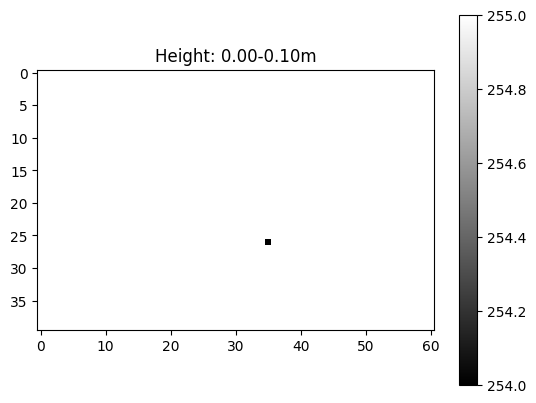

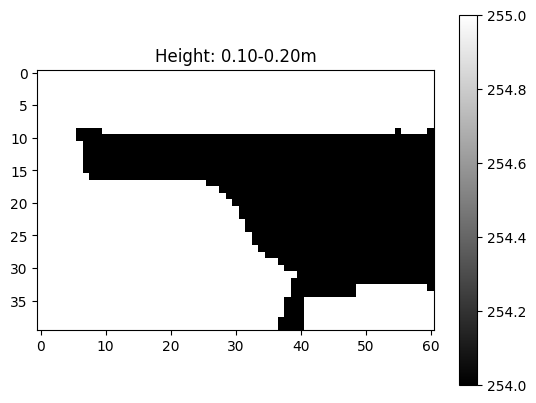

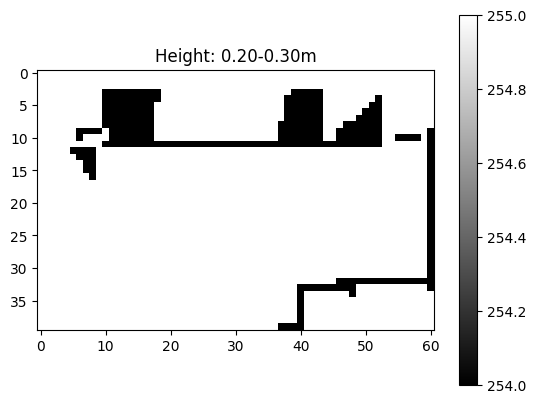

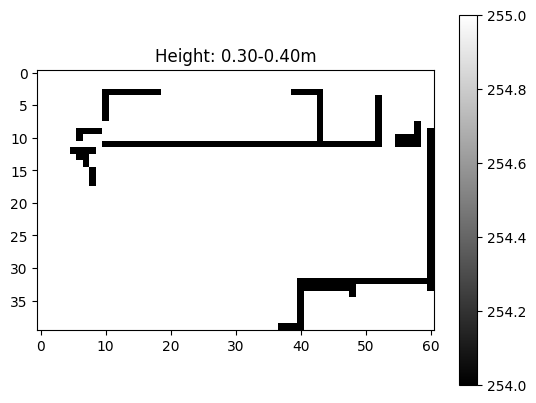

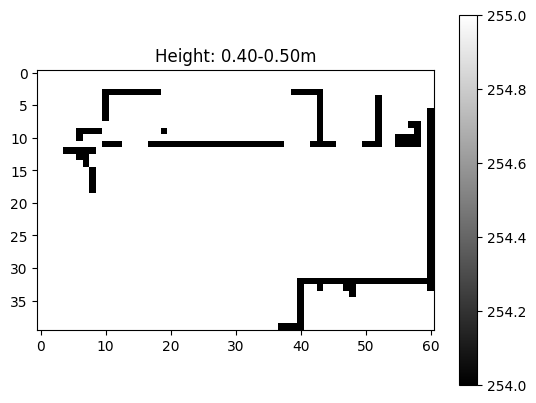

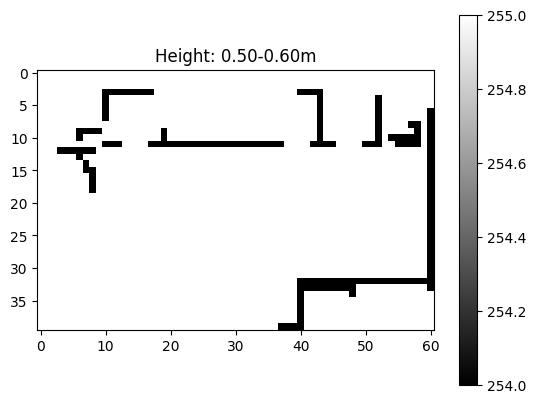

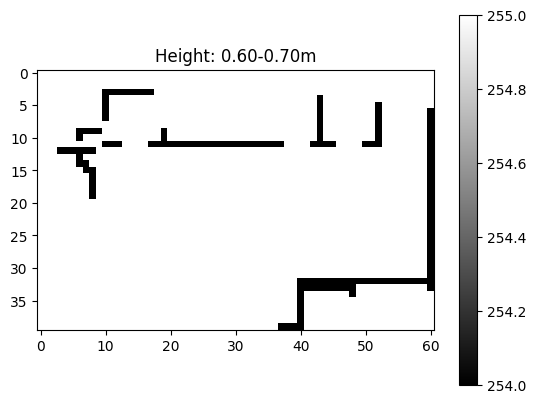

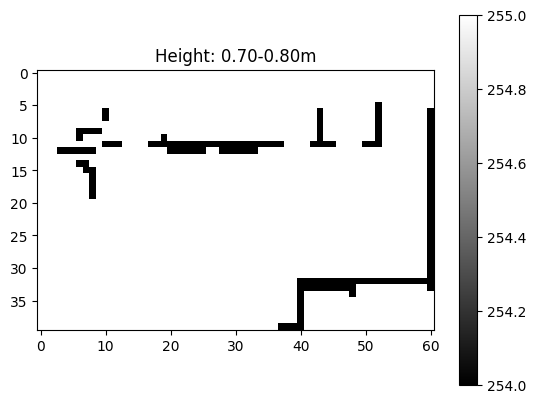

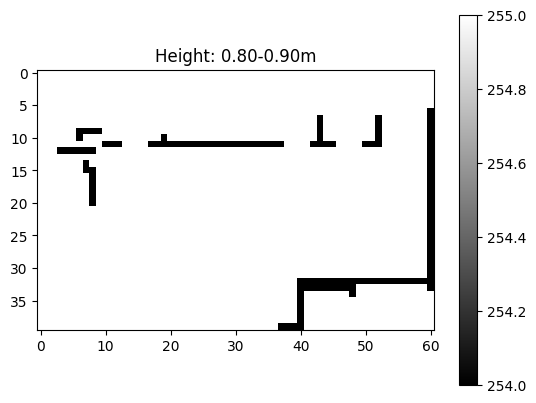

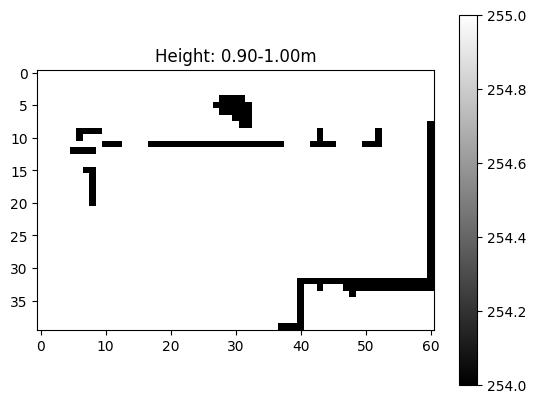

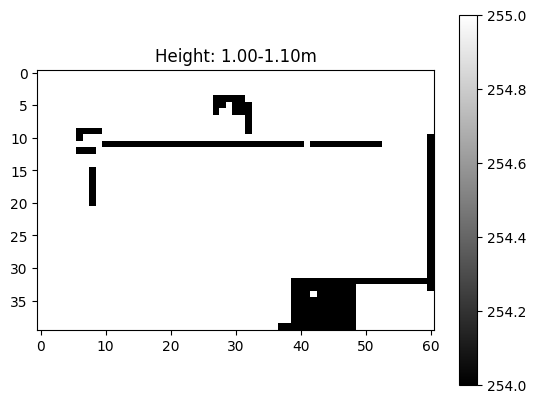

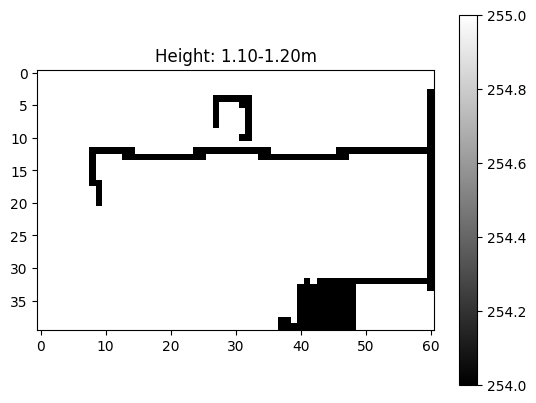

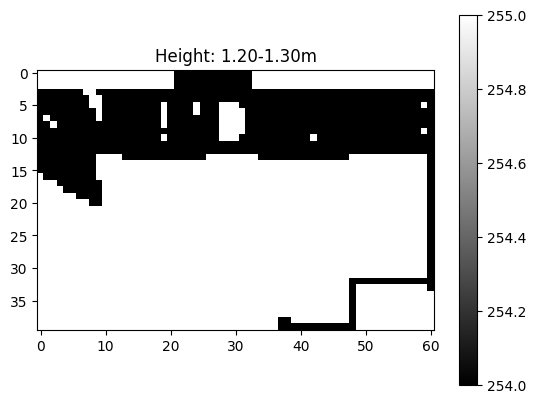

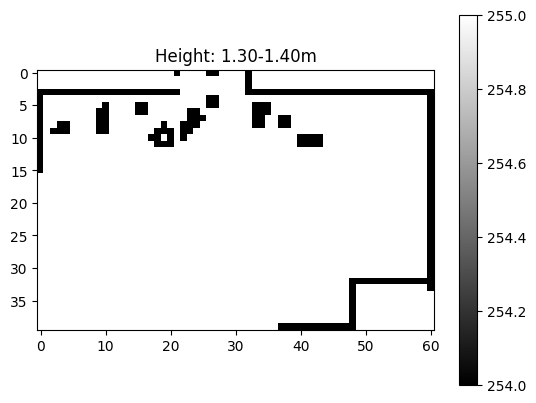

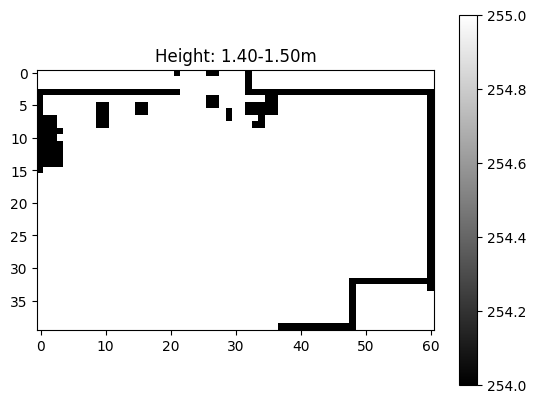

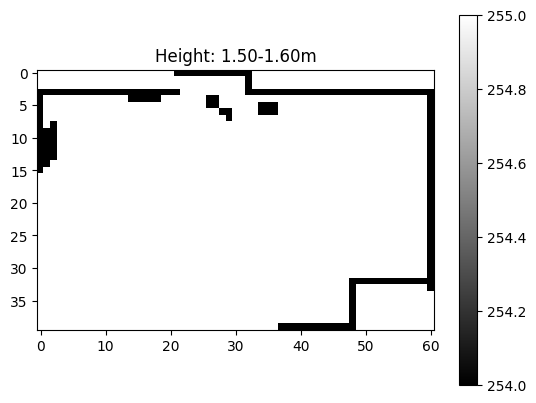

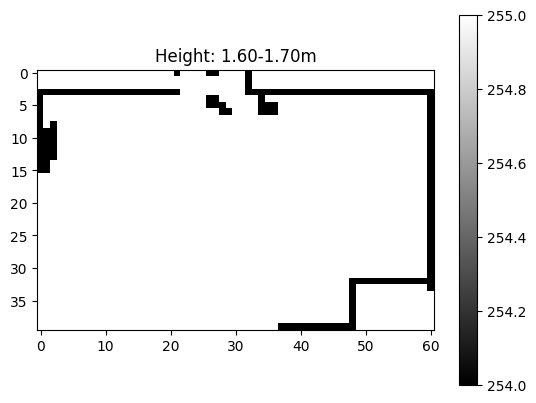

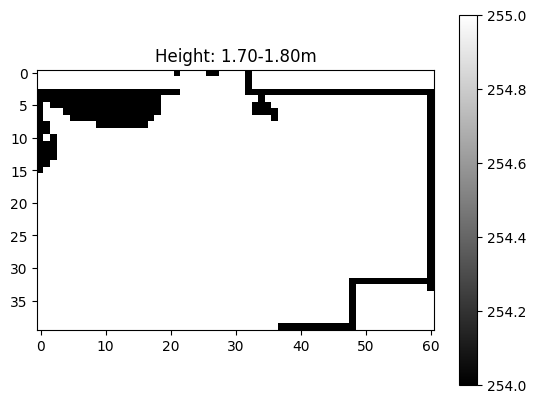

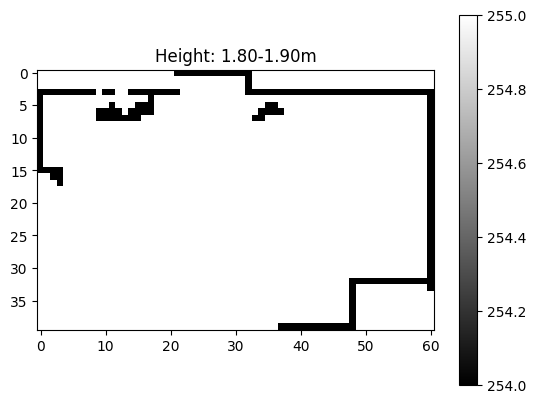

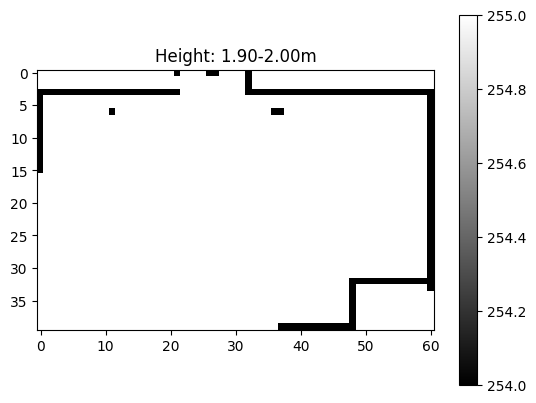

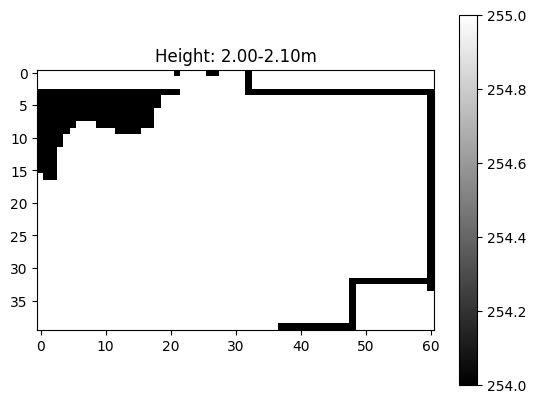

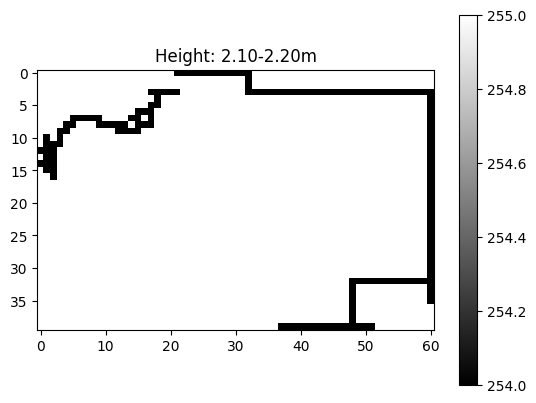

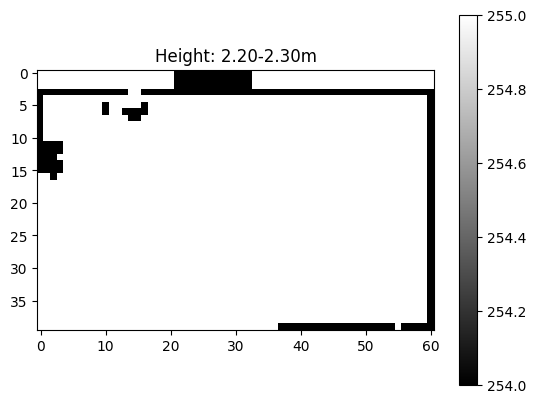

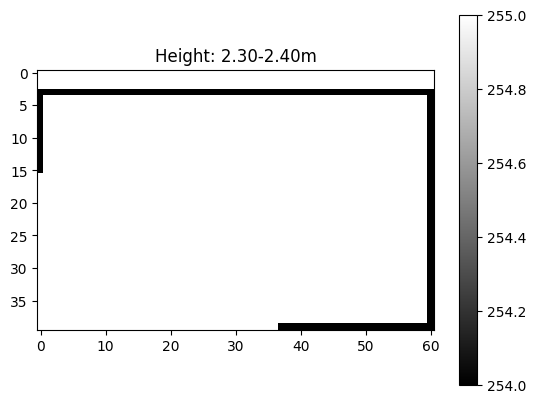

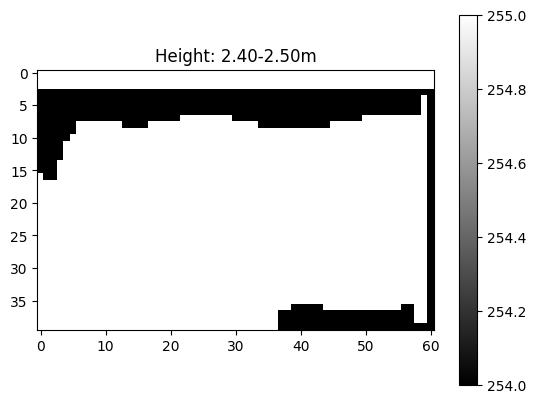

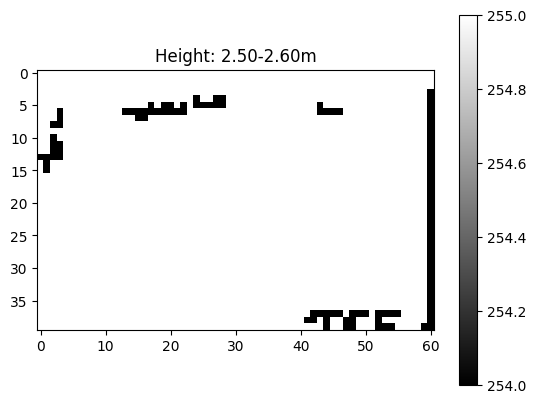

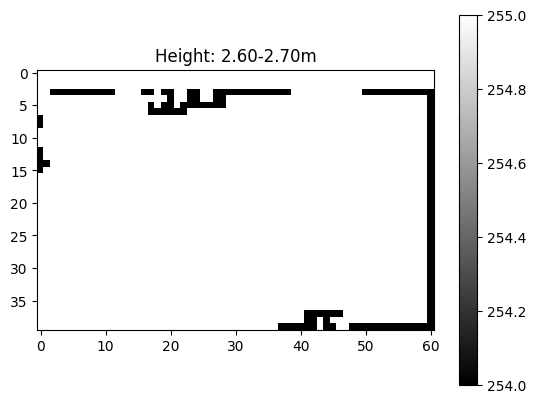

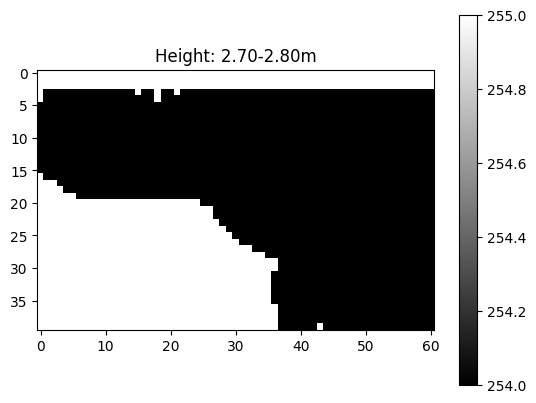

In [20]:
##############################################################################
# TODO: Do tasks described in 2.6
##############################################################################

def create_occupancy_grid(point_cloud, grid_resolution):
    points = np.asarray(point_cloud.points)
    
    bounding_box = point_cloud.get_axis_aligned_bounding_box()
    min_bound = bounding_box.min_bound
    max_bound = bounding_box.max_bound

    height_slices = [(i, i + grid_resolution) for i in np.arange(min_bound[1], max_bound[1], grid_resolution)]
    
    occupancy_grids = []
    for z_min, z_max in height_slices:
        slice_points = points[(points[:, 1] >= z_min) & (points[:, 1] < z_max)]
        if len(slice_points) == 0:
            continue

        x_indices = ((slice_points[:, 0] - min_bound[0]) / grid_resolution).astype(int)
        y_indices = ((slice_points[:, 2] - min_bound[2]) / grid_resolution).astype(int)
        
        grid_max_x = int(np.ceil((max_bound[0] - min_bound[0]) / grid_resolution))
        grid_max_y = int(np.ceil((max_bound[2] - min_bound[2]) / grid_resolution))
        grid = np.zeros((grid_max_y, grid_max_x))
        
        grid[y_indices, x_indices] = 1
        
        occupancy_grids.append(grid)
    
    return occupancy_grids, height_slices

def visualize_occupancy_grids(occupancy_grids, height_slices):
    for grid, (z_min, z_max) in zip(occupancy_grids, height_slices):
        plt.imshow(255 - grid, cmap='gray')
        plt.title(f'Height: {z_min:.2f}-{z_max:.2f}m')
        plt.colorbar()
        plt.show()


pcd = o3d.io.read_point_cloud("results/stiched_point_cloud/final_point_cloud.pcd")
grid_resolution = 0.1 
grids, height_slices = create_occupancy_grid(pcd, grid_resolution)
visualize_occupancy_grids(grids, height_slices)

##############################################################################
# END OF YOUR CODE
##############################################################################

### (OPTIONAL) SECTION 3: Mapping using 3D LiDAR
This question is similar to section 2 but with LiDAR point cloud.

Your task is to fuse image data from a camera with the measurements from a LiDAR (a laser scanner with a 360° field-of-view that records distance measurements) and associate every point in the image with accurate distance measurements. 

The LiDAR’s frame is defined such that its X-axis points forward, its Y-axis points to the left, and its Z-axis points upwards. And the camera’s frame is defined such that its Z-axis points forward, X-axis points to the right, and Y-axis points downwards. The camera’s center is 8 cm below, 6 cm to the left, and 27 cm in front of the LiDAR’s center (found via extrinsic calibration and as measured by the LiDAR). Both the sensors are positioned such that the camera’s Z-axis and the LiDAR’s X-axis are perfectly parallel. Refer to the figure below for more details. 

<img src="misc/lidar.png" alt="drawing" width="500"/>

A LiDAR frame and its corresponding camera image have been provided as data/lidar-points.bin and data/image.png, respectively. The camera calibration matrix, K, is provided inside data/K.txt.

Code for loading the LiDAR points in Python is provided.

In [ ]:
def load_velodyne_points(points_path):
    points = np.fromfile(points_path, dtype=np.float32).reshape(-1, 4)
    points = points[:,:3]                # exclude reflectance values, becomes [X Y Z]
    points = points[1::5,:]              # remove every 5th point for display speed (optional)
    points = points[(points[:,0] > 5)]   # remove all points behind image plane (approximate)
    return points

3.1 Compute the transformation (R, t) required to transform points in the LiDAR’s frame to the
camera’s frame. Give the transformation in both 
(a) homogeneous matrix form
(b) XYZ Euler angles (RPY)-translation form.

In [ ]:
##############################################################################
# TODO: Do tasks described in 3.1
##############################################################################

# Replace "pass" statement with your code
pass

##############################################################################
# END OF YOUR CODE
##############################################################################

3.2 Then, using this computed transformation and the provided camera calibration matrix, project the LiDAR’s points onto the image plane. Use the color code (colormap) to correspond the depth of the points in the image (color is optional, but it helps in debugging). Use matplotlib or any equivalent library for plotting the points on the image. Visualize the image in this notebook. 

In [ ]:
##############################################################################
# TODO: Do tasks described in 3.2
##############################################################################

# Replace "pass" statement with your code
pass

##############################################################################
# END OF YOUR CODE
##############################################################################